In [1]:
import numpy as np
import skimage
import skimage.io
from skimage.filters import gaussian
import os
import glob
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from RunMain import VGG_16
import CallResult
import matplotlib.pyplot as plt
import h5py as h5
%matplotlib inline
import cv2

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)


In [33]:
def make_masked_image(image, mask_img, threshold, blur=False, blur_amount=10):
    mask = mask_img < threshold
    result = image.copy()
    if blur:
        # back_image = gaussian(image, blur_amount)
        # back_image = skimage.img_as_ubyte(back_image)
        back_image = cv2.GaussianBlur(image, (0,0), blur_amount)
    else:
        back_image = np.zeros(image.shape)
    result[mask] = back_image[mask]
    return result

def compile_results(out):
    ordered_idx = np.argsort(-out)
            
    full_result = [(
        CallResult.lines[int(idx)].split()[0], 
        CallResult.lines[int(idx)], 
        idx, 
        out[0][idx]) 
        for idx in ordered_idx[0]
    ]
    
    return full_result

def test_image_at_levels(image_name, percentages, model, blur=False, blur_amount=10):
    """ Perform the classification accuracy test for the given image

    Args:
        image_name (string): The name of the image to test (should be in IMAGE_DIR)
        percetages list(int): A list of percentiles to use for tests e.g. [25,50,100]
        model object: the model to use for classification
        blur (boolean): whether to blur or leave background black
        blur_amount (float): the amounf of blur to apply
    """
    results_dict = {
        'valid_WNID' : VAL_LABELS[get_im_idx(image_name)-1],
        'valid_callresult' : get_VGG_map(VAL_LABELS[get_im_idx(image_name)-1]),
        'image_name' : image_name,
        'percentages' : percentages,
        'full_results' : [],
        'trajectories' : {}
    }
    print(results_dict)
    # img = skimage.io.imread(os.path.join(IMAGE_DIR, image_name[:-3]+'JPEG'))
    img = cv2.imread(os.path.join(IMAGE_DIR, image_name[:-3]+'JPEG'))
#     plt.imshow(img)
    # mask_img = skimage.io.imread(os.path.join(MASK_DIR, image_name))
    mask_img = cv2.imread(os.path.join(MASK_DIR, image_name))
    results = []
    level_list = get_ntiles_for_img(mask_img, percentages)
#     print(level_list)
    for level in level_list:
        masked_image = make_masked_image(img, mask_img, level, blur, blur_amount)
#         cv2.imshow('img',masked_image)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        # Transform image for VGG
        masked_image = cv2.resize(masked_image, (224,224)).astype(np.float32)
        masked_image[:,:,0] -= 103.939
        masked_image[:,:,1] -= 116.779
        masked_image[:,:,2] -= 123.68
        masked_image = masked_image.transpose((1,0,2))
        masked_image = np.expand_dims(masked_image, axis=0)
        out = model.predict(masked_image)
        full_result = compile_results(out)
        
        results_dict['full_results'].append(full_result)
        if 'best_guess' not in results_dict: 
            results_dict['best_guesses'] = (full_result[0:5],level)
            
        # loop all softmax outputs
        for result in full_result:
            # make sure WNID [] exists
            if result[0] not in results_dict['trajectories']: results_dict['trajectories'][result[0]] = []
            results_dict['trajectories'][result[0]].append(result[-1])

    return results_dict

def get_ntiles_for_img(img, percentages):
    """ Split calculate """
    percentiles = []
    for i in percentages:
        percentiles.append(np.percentile(img, i))
    return percentiles

def get_im_idx(file):
    return int(file.split('_')[-1].split('.')[0])

def get_VGG_map(WNID):
    match = None
    for line in CallResult.lines:
        if WNID in line: match = line
    return match

In [3]:
# Make VGG model
VGG_WEIGHTS = '/n/regal/cox_lab/dapello/VGG16_Keras_TensorFlow/data/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
model = VGG_16(VGG_WEIGHTS)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

/n/regal/cox_lab/dapello/saccadinator/RunMain.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(64, 3, 3, activation='relu'))
/n/regal/cox_lab/dapello/saccadinator/RunMain.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(64, 3, 3, activation='relu'))
/n/regal/cox_lab/dapello/saccadinator/RunMain.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(128, 3, 3, activation='relu'))
/n/regal/cox_lab/dapello/saccadinator/RunMain.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(128, 3, 3, activation='relu'))
/n/regal/cox_lab/dapello/saccadinator/RunMain.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add

In [4]:
IMAGE_DIR = '/n/regal/cox_lab/dapello/saliency-salgan-2017/images/ILSVRC2012_val/'
MASK_DIR = '/n/regal/cox_lab/dapello/saliency-salgan-2017/saliency/ILSVRC2012_val/'
IMAGE_NAMES = []
VAL_LABELS = [line.replace('\n','') for line in open('ground_truth_sane.txt')]

for img_name in glob.glob(os.path.join(MASK_DIR, '*')):
    IMAGE_NAMES.append(os.path.split(img_name)[-1])

{'valid_WNID': 'n02119789', 'valid_callresult': 'n02119789 kit fox, Vulpes macrotis\n', 'image_name': 'ILSVRC2012_val_00000001.jpg', 'percentages': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]), 'full_results': [], 'trajectories': {}}
([('n03627232', 'n03627232 knot\n', 616, 0.090707675), ('n03532672', 'n03532672 hook, claw\n', 600, 0.078731231), ('n02999410', 'n02999410 chain\n', 488, 0.074412204), ('n01740131', 'n01740131 night snake, Hypsiglena torquata\n', 60, 0.050608959), ('n01729322', 'n01729322 hognose snake, puff adder, sand viper\n', 54, 0.046400819)], 48.0)


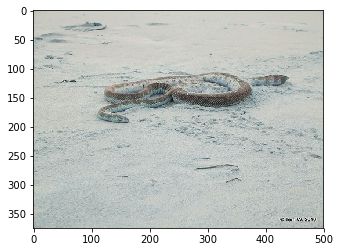

In [32]:
ntiles = np.arange(1,101,10)
im_name = IMAGE_NAMES[1512]
results_dict = test_image_at_levels(im_name, ntiles, model, blur=True)
print(results_dict['best_guesses'])

In [34]:
results_array = []
ntiles = np.arange(0,101,10)
for image_name in IMAGE_NAMES[0:5]:
    results_dict = test_image_at_levels(image_name, ntiles, model, blur=True)
    results_array.append(results_dict)

results_array_np = np.array(results_array)
np.savez('results_array',results_array_np)

{'valid_WNID': 'n02417914', 'valid_callresult': 'n02417914 ibex, Capra ibex\n', 'image_name': 'ILSVRC2012_val_00001459.jpg', 'percentages': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]), 'full_results': [], 'trajectories': {}}
{'valid_WNID': 'n02119789', 'valid_callresult': 'n02119789 kit fox, Vulpes macrotis\n', 'image_name': 'ILSVRC2012_val_00000324.jpg', 'percentages': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]), 'full_results': [], 'trajectories': {}}
{'valid_WNID': 'n02123394', 'valid_callresult': 'n02123394 Persian cat\n', 'image_name': 'ILSVRC2012_val_00002024.jpg', 'percentages': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]), 'full_results': [], 'trajectories': {}}
{'valid_WNID': 'n02096294', 'valid_callresult': 'n02096294 Australian terrier\n', 'image_name': 'ILSVRC2012_val_00002421.jpg', 'percentages': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]), 'full_results': [], 'trajectories': {}}
{'valid_WNID': 'n02102040', 'valid_callresult': 'n02102040 English springer, En

In [15]:
for img_idx in range(len(IMAGE_NAMES)):
    if '00000001' in IMAGE_NAMES[img_idx]: print(img_idx, IMAGE_NAMES[img_idx])

1512 ILSVRC2012_val_00000001.jpg


In [48]:
VAL_LABELS[get_im_idx(IMAGE_NAMES[2])]

'n02110185'

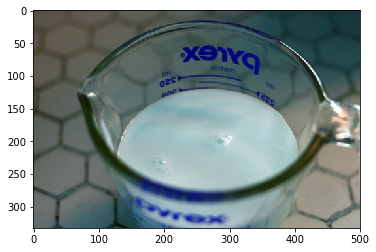

In [56]:
plt.imshow(img)

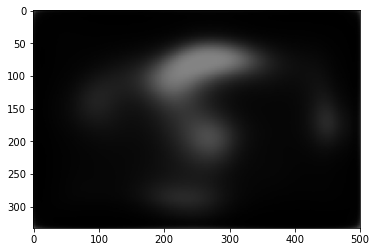

In [54]:
plt.imshow(mask_img)